In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

In [2]:
# Load datasets
train_dir = "train_cleaned.csv"
test_dir = "test.csv"

# Read the data
train_data = pd.read_csv(train_dir)
#test_data = pd.read_csv(test_dir)

In [3]:
train_data.head()

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Hospital_code_10,Hospital_code_11,...,City_Code_Patient_35,City_Code_Patient_36,City_Code_Patient_37,City_Code_Patient_38,City_Code_Patient_4,City_Code_Patient_5,City_Code_Patient_6,City_Code_Patient_7,City_Code_Patient_8,City_Code_Patient_9
0,0.125000,0.333333,1.0,1.0,0.0625,0.555556,0.337858,0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.451129,4,False,False,...,False,False,False,False,False,False,False,True,False,False
2,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.319831,3,True,False,...,False,False,False,False,False,False,False,True,False,False
3,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.594266,4,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.083333,0.333333,0.0,1.0,0.0625,0.555556,0.408123,4,False,False,...,False,False,False,False,False,False,False,True,False,False


In [4]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
print(X_train)

        Available Extra Rooms in Hospital  Bed Grade  Type of Admission  \
291926                           0.083333   1.000000                0.0   
300988                           0.166667   1.000000                1.0   
222241                           0.166667   0.666667                0.0   
195018                           0.208333   0.333333                1.0   
117009                           0.041667   0.666667                1.0   
...                                   ...        ...                ...   
290734                           0.125000   1.000000                1.0   
15291                            0.083333   1.000000                0.0   
24299                            0.083333   1.000000                1.0   
205631                           0.083333   0.666667                1.0   
185431                           0.166667   0.333333                0.0   

        Severity of Illness  Visitors with Patient       Age  \
291926                  0.0        

In [6]:
xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=len(set(y_train)), eval_metric="mlogloss")

In [7]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=11, num_parallel_tree=None, ...)

In [8]:
y_pred = xgb_clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4236
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15      0.22      4721
           1       0.43      0.49      0.46     15628
           2       0.42      0.67      0.52     17498
           3       0.43      0.22      0.29     11032
           4       0.14      0.00      0.01      2349
           5       0.40      0.50      0.45      7004
           6       0.00      0.00      0.00       549
           7       0.34      0.04      0.07      2051
           8       0.38      0.22      0.28       967
           9       0.37      0.03      0.05       553
          10       0.55      0.42      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.35      0.25      0.26     63688
weighted avg       0.41      0.42      0.39     63688

Confusion Matrix:
 [[  729  2251  1690    35     2    12     0     0     0     0     2]
 [  415  7687  6281   732     7   487     2    11     1   

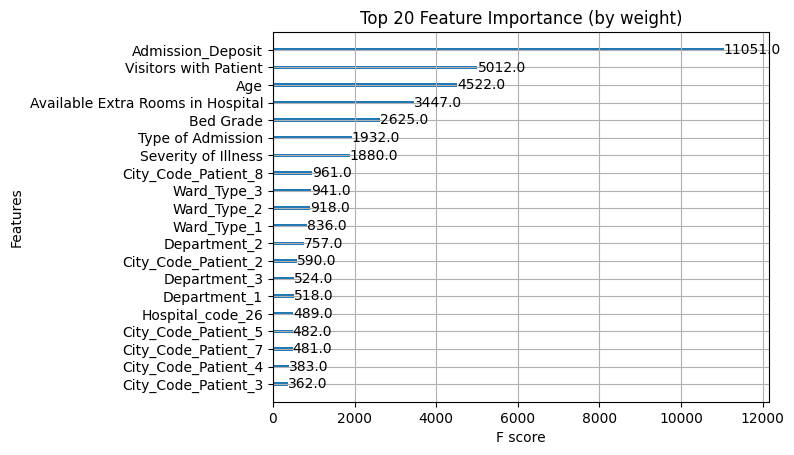

In [9]:
xgb.plot_importance(xgb_clf, importance_type="weight", max_num_features=20)
plt.title("Top 20 Feature Importance (by weight)")
plt.show()

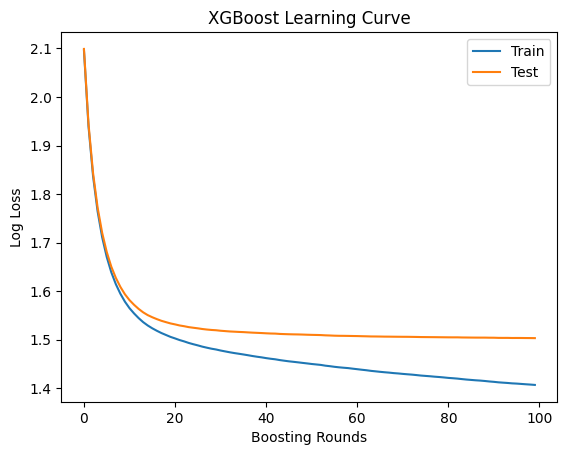

In [10]:
results = xgb_clf.evals_result()

epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

plt.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")

plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()

In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold

In [12]:
X_train

,Available Extra Rooms in Hospital,Bed Grade,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Hospital_code_10,Hospital_code_11,Hospital_code_12,...,City_Code_Patient_35,City_Code_Patient_36,City_Code_Patient_37,City_Code_Patient_38,City_Code_Patient_4,City_Code_Patient_5,City_Code_Patient_6,City_Code_Patient_7,City_Code_Patient_8,City_Code_Patient_9
291926,0.083333,1.000000,0.0,0.0,0.06250,0.222222,0.198306,False,False,False,...,False,False,False,False,False,False,False,False,True,False
300988,0.166667,1.000000,1.0,0.5,0.06250,0.222222,0.285838,False,False,False,...,False,False,False,False,False,False,False,False,False,False
222241,0.166667,0.666667,0.0,0.5,0.31250,0.444444,0.310165,False,True,False,...,False,False,False,False,False,False,False,False,False,False
195018,0.208333,0.333333,1.0,1.0,0.06250,0.333333,0.240660,False,False,False,...,False,False,False,False,False,True,False,False,False,False
117009,0.041667,0.666667,1.0,0.5,0.31250,0.444444,0.221329,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290734,0.125000,1.000000,1.0,0.0,0.06250,0.555556,0.116095,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15291,0.083333,1.000000,0.0,0.5,0.06250,0.777778,0.326347,False,False,False,...,False,False,False,False,False,True,False,False,False,False
24299,0.083333,1.000000,1.0,0.5,0.12500,0.666667,0.273675,False,False,False,...,False,False,False,False,False,False,False,False,True,False
205631,0.083333,0.666667,1.0,0.0,0.09375,0.333333,0.363162,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [13]:
def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": len(set(y_train)),
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True),
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    acc_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train[train_idx], X_train[valid_idx]
        y_train_fold, y_valid_fold = y_train[train_idx], y_train[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_valid_fold)
        acc_scores.append(accuracy_score(y_valid_fold, y_pred))

    return sum(acc_scores) / len(acc_scores)

In [14]:
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

print("Class distribution in y_train:", train_counts)
print("Class distribution in y_test:", test_counts)

Class distribution in y_train: [18883 62511 69993 44127  9394 28014  2195  8203  3871  2212  5347]
Class distribution in y_test: [ 4721 15628 17498 11032  2349  7004   549  2051   967   553  1336]


In [15]:
print("y_train unique values:", np.unique(y_train))
print("y_test unique values:", np.unique(y_test))

y_train unique values: [ 0  1  2  3  4  5  6  7  8  9 10]
y_test unique values: [ 0  1  2  3  4  5  6  7  8  9 10]


In [16]:
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
X_train = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-04-03 12:09:34,113] A new study created in memory with name: no-name-6a7e6b36-0d8c-4609-9c08-e6d020052401
[W 2025-04-03 12:09:50,668] Trial 0 failed with parameters: {'max_depth': 3, 'learning_rate': 0.015857906791575525, 'n_estimators': 171, 'subsample': 0.8079690062023478, 'colsample_bytree': 0.8831767005642668, 'reg_lambda': 9.42417519834103, 'reg_alpha': 0.02890879270184271} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\JScot\AppData\Local\Temp\ipykernel_23312\1521467301.py", line 24, in objective
    model.fit(X_train_fold, y_train_fold)
  File "C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\

KeyboardInterrupt: 

In [21]:
best_params = study.best_params
print("Best Parameters:", best_params)

ValueError: No trials are completed yet.

In [22]:
best_xgb_clf = xgb.XGBClassifier(**best_params)
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

NameError: name 'best_params' is not defined

In [ ]:
best_xgb_clf.save_model("best_xgb_model.json")

In [24]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
best_xgb_clf = xgb.XGBClassifier()
best_xgb_clf.load_model("best_xgb_model.json")
best_xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBClassifier(base_score='5E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i',
                             'i'...
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [26]:
# Final evaluation
y_pred = best_xgb_clf.predict(X_test)
print(f"Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Final Accuracy: 0.4236
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15      0.22      4721
           1       0.43      0.49      0.46     15628
           2       0.42      0.67      0.52     17498
           3       0.43      0.22      0.29     11032
           4       0.14      0.00      0.01      2349
           5       0.40      0.50      0.45      7004
           6       0.00      0.00      0.00       549
           7       0.34      0.04      0.07      2051
           8       0.38      0.22      0.28       967
           9       0.37      0.03      0.05       553
          10       0.55      0.42      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.35      0.25      0.26     63688
weighted avg       0.41      0.42      0.39     63688

Confusion Matrix:
 [[  729  2251  1690    35     2    12     0     0     0     0     2]
 [  415  7687  6281   732     7   487     2    11   

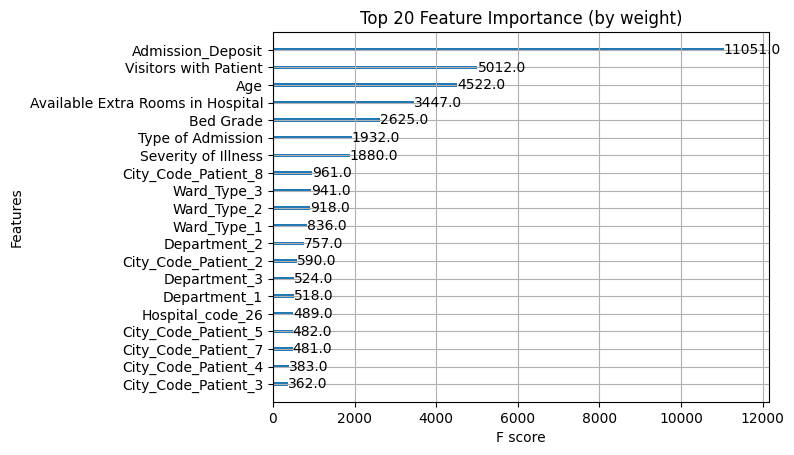

In [27]:
xgb.plot_importance(best_xgb_clf, importance_type="weight", max_num_features=20)
plt.title("Top 20 Feature Importance (by weight)")
plt.show()

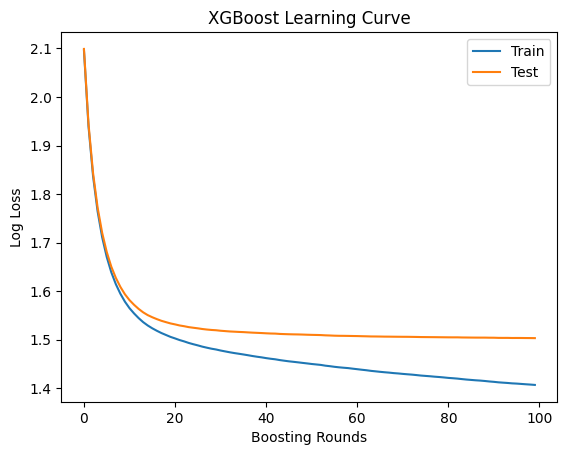

In [28]:
results = best_xgb_clf.evals_result()

epochs = len(results["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

plt.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["mlogloss"], label="Test")

plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.show()

In [29]:
def weighted_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds.reshape(-1, len(np.unique(labels))), axis=1)
    weights = 1 / (1 + np.abs(labels - preds))
    return "weighted_accuracy", np.mean(weights)

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define model parameters
params = {
    "objective": "multi:softprob",  # Softprob for multi-class classification
    "num_class": len(np.unique(y_train)),
    "eval_metric": "mlogloss"  # Default metric, can include others
}

In [ ]:
weighted_xgb_clf = xgb.train(
    params,
    dtrain,
    num_boost_round=250,
    evals=[(dtrain, "train")],
    feval=weighted_accuracy,
    verbose_eval=True
)

C:\Users\JScot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-mlogloss:2.09628	train-weighted_accuracy:0.63980
[1]	train-mlogloss:1.93978	train-weighted_accuracy:0.64325
[2]	train-mlogloss:1.83699	train-weighted_accuracy:0.64487
[3]	train-mlogloss:1.76435	train-weighted_accuracy:0.64688
[4]	train-mlogloss:1.71115	train-weighted_accuracy:0.64798
[5]	train-mlogloss:1.67070	train-weighted_accuracy:0.64896
[6]	train-mlogloss:1.63915	train-weighted_accuracy:0.64952
[7]	train-mlogloss:1.61459	train-weighted_accuracy:0.65006
[8]	train-mlogloss:1.59481	train-weighted_accuracy:0.65074
[9]	train-mlogloss:1.57846	train-weighted_accuracy:0.65144
[10]	train-mlogloss:1.56513	train-weighted_accuracy:0.65186
[11]	train-mlogloss:1.55430	train-weighted_accuracy:0.65220
[12]	train-mlogloss:1.54470	train-weighted_accuracy:0.65269
[13]	train-mlogloss:1.53636	train-weighted_accuracy:0.65312
[14]	train-mlogloss:1.52948	train-weighted_accuracy:0.65358
[15]	train-mlogloss:1.52365	train-weighted_accuracy:0.65394
[16]	train-mlogloss:1.51857	train-weighted_accurac

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = np.argmax(weighted_xgb_clf.predict(dtest), axis=1)

# Standard evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [ ]:
def weighted_accuracy_test(y_true, y_pred):
    weights = 1 / (1 + np.abs(y_true - y_pred))
    return np.mean(weights)

# Compute weighted accuracy on test data
weighted_acc_test = weighted_accuracy_test(y_test, y_pred)
print(f"Weighted Accuracy (Test Set): {weighted_acc_test:.4f}")

In [ ]:
test = pd.read_csv("test_cleaned.csv")

In [ ]:
test.head()

In [ ]:
case_ids = test["case_id"]
Pred_test = test.drop(columns=["case_id"])

In [ ]:
dtest = xgb.DMatrix(Pred_test)

# Make predictions using the trained model
y_pred = best_xgb_clf.predict(Pred_test)

In [ ]:
stay_mapping = {
    0: "0-10",
    1: "11-20",
    2: "21-30",
    3: "31-40",
    4: "41-50",
    5: "51-60",
    6: "61-70",
    7: "71-80",
    8: "81-90",
    9: "91-100",
    10: "More than 100"
}

y_pred_labels = [stay_mapping[pred] for pred in y_pred]

In [ ]:
predictions_df = pd.DataFrame({
    "case_id": case_ids,
    "Stay": y_pred_labels
})

predictions_df.to_csv("predictions.csv", index=False)